# Example: MMNL Assortment Optimization (Unconstrained)

This notebook demonstrates how to test an algorithm for the hard instances of the ** Mixed Multinomial Logit (MMNL)** choice model under the unconstrained setting.

It shows how to:
1. Load the instance
2. Run a method for the instances
3. Interpret the results provided by the algorithms.

## 1. Import Required Modules


In [12]:
import sys
import os
import json

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)  # get the project root directory
sys.path.append(project_root)

from generator.mmnl_data_generator import *
from generator.utils  import *
from generator.constraint import *
from models.mmnl_functions import *
from method.mmnl_method import *
from method.general_method import *
from plot import *

%load_ext autoreload
%autoreload 2
print("✅ Modules imported successfully.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Modules imported successfully.


## 2. Unconstrained Assortment Optimization

In this section, we solve the assortment optimization problem without any additional constraints. 

### 2.1 Load Data
- We provide two json files in the hard_data file based on different revenue curves
- The number of products $n \in \{50, 100, 200\}$
- The number of customer segements $m \in \{5, 10, 25\}$
- The revenue curves include RS2 and RS4

In [2]:
hard_instance_dir = project_root + "/hard_data/"
rev_method = 'RS2'
unconstrained_dir = "mmnl_unconstrained_"
# cardinality_dir = "mmnl_card_"
input_json_path = hard_instance_dir + unconstrained_dir + rev_method + "_data.json"
instances = load_MMNL_instances(input_json_path)

DATASET STRUCTURE SUMMARY


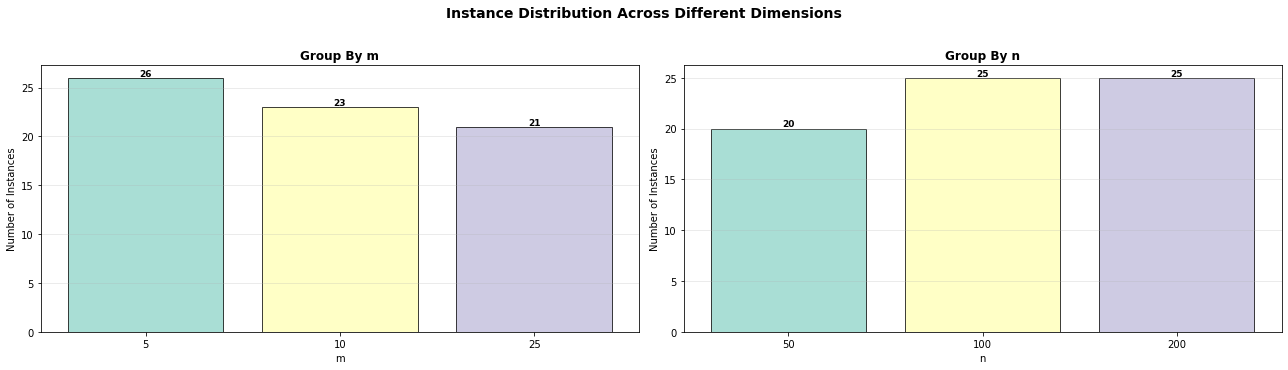

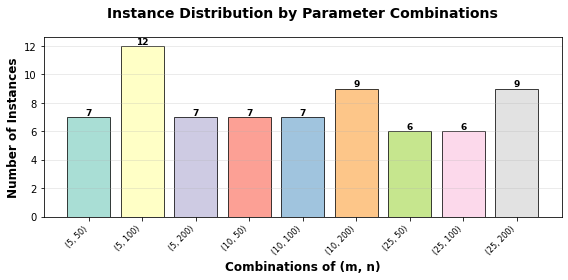

In [3]:
group_cols=['m', 'n']
plot_instance_summary(instances,group_cols)

### 2.2 Demonstrate the Structure of the Instance

No handles with labels found to put in legend.


INSTANCE OVERVIEW
Number of nests (m): 5
Number of products per nest (n): 50
Total number of products: 250
Random seed: 3
Capacity rate: 1
Maximum revenue (optimal): 0.4327

DATA COMPONENTS - DIMENSIONS
1. Utility Matrix (u): shape (5, 50), range: [0.0005, 21354.0896]
2. Product Prices (price): shape (1, 50),range: [0.2000, 1.0000]
3. No-Purchase Utility value (v0): [2.23580091 3.45897636 2.41264389 4.38802549 2.45984647]
4. Customer Segment Probabilities (omega): shape (5,), sum: 1.0000 (should be 1.0)

DATA VISUALIZATION


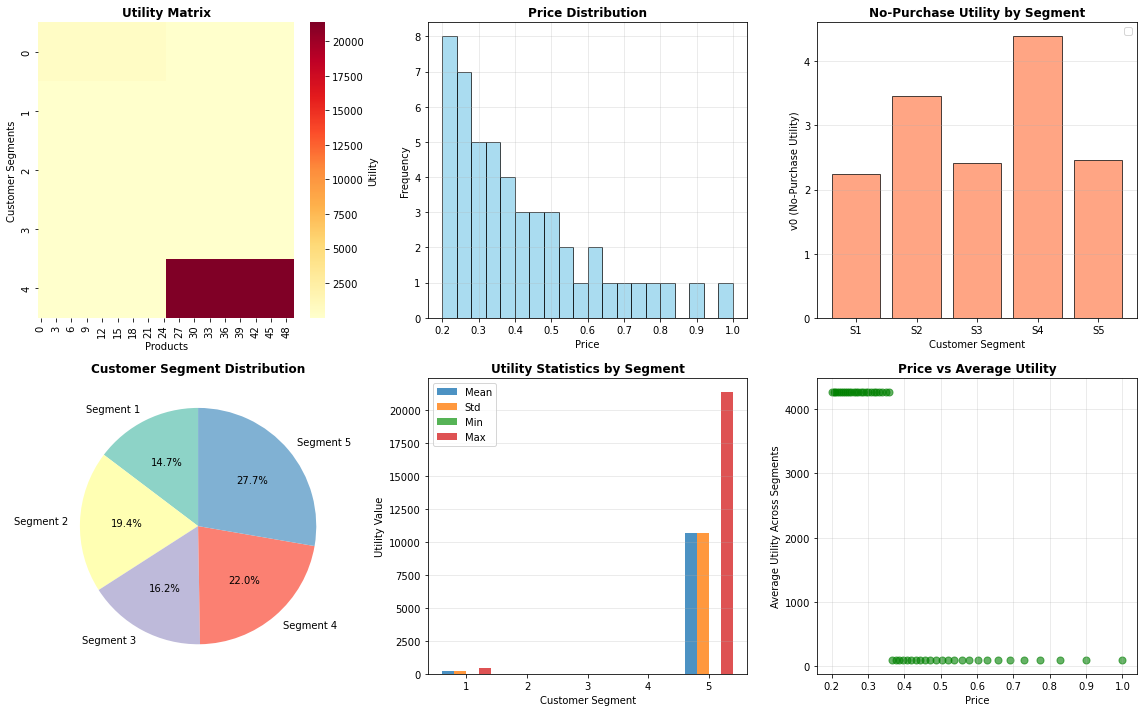

In [4]:
data = instances[3] # select an instance to explore
model_type = "MMNL"
explore_instance(data, model_type)

### 2.3 Run Algorithm on All Instances

In [5]:
# Initialize data paths and result storage
hard_instance_dir = project_root + "/hard_data/"
rev_method_list = ['RS2', 'RS4']  # Two revenue curve methods to test
results = []

# Loop through each revenue method
for rev_method in rev_method_list:
    # Load instances for the current revenue method
    input_json_path = hard_instance_dir + unconstrained_dir + rev_method + "_data.json"
    instances = load_MMNL_instances(input_json_path)
    
    print(f"\nProcessing {rev_method}...")
    
    # Process each instance
    for idx, data in enumerate(instances):
        # Get the revenue function for this instance
        revenue_fn = get_revenue_function_mmnl(data)
        
        # Run the revenue-ordered heuristic algorithm
        # rev_order: best revenue found
        # k: number of products selected
        # best_ass: best assortment found (binary vector)
        rev_order, k, best_ass = revenue_order('mmnl', data)
        
        # Calculate again the revenue achieved by the heuristic
        revenue = revenue_fn(best_ass)[0]
        
        # Get the optimal revenue (from exact solution)
        opt_rev = data.max_rev
        
        # Calculate the optimality gap (in percentage)
        gap_method = (opt_rev - revenue) / opt_rev * 100
        
        # Store results for this instance
        result_dict = {
            'm': data.m,                    # Number of customer segments
            'n': data.n,                    # Number of products
            'rev_method': rev_method,       # Revenue curve method (RS2 or RS4)
            'cap_rate': data.cap_rate,      # Capacity rate
            'seed': data.seed,              # Random seed for reproducibility
            'max_rev': opt_rev,             # Optimal revenue
            'gap_method': gap_method        # Optimality gap (%)
        }
        
        results.append(result_dict)

print(f"\n✅ Completed testing on {len(results)} instances.")


Processing RS2...

Processing RS4...

✅ Completed testing on 156 instances.


### 2.4 Save Detailed Statistics to Excel

In [13]:
# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Create a combined column for (m, n) pairs for easier grouping
df_results['m_n'] = df_results['m'].astype(str) + '_' + df_results['n'].astype(str)

print(f"Total instances tested: {len(df_results)}")
print(f"Revenue methods: {df_results['rev_method'].unique().tolist()}")
print(f"(m, n) combinations: {sorted(df_results['m_n'].unique().tolist())}")

output_dir = project_root + "/results/"
file_name="mmnl_summary_statistics.xlsx"
method_col="rev_method"
export_summary_statistics(df_results,output_dir,file_name,method_col)

Total instances tested: 156
Revenue methods: ['RS2', 'RS4']
(m, n) combinations: ['10_100', '10_200', '10_50', '25_100', '25_200', '25_50', '5_100', '5_200', '5_50']


### 2.5 Visualize Algorithm Performance

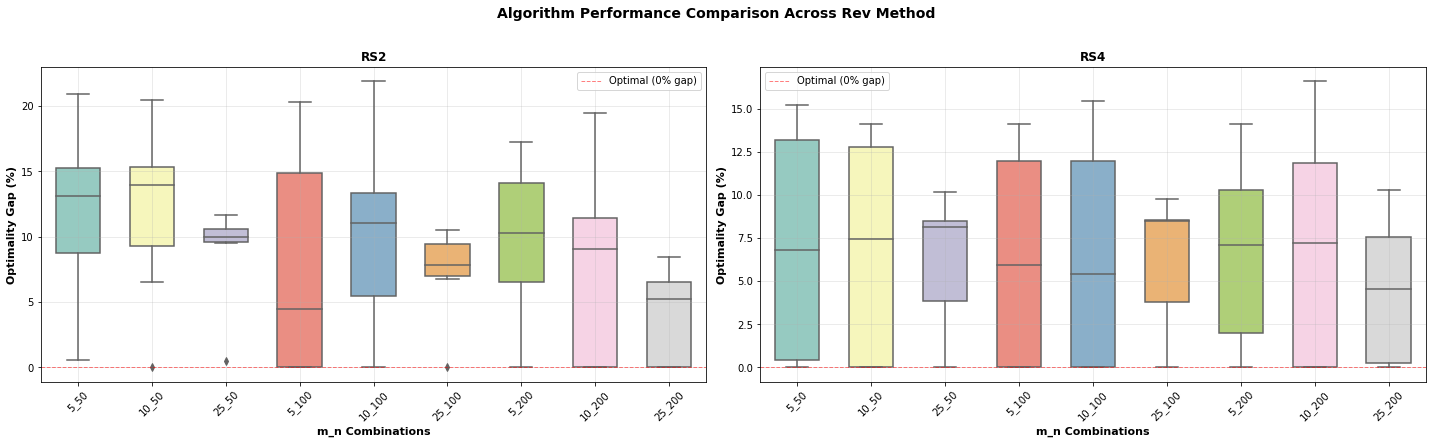


RS2 Performance Summary:
           mean     std     min      max
m_n                                     
10_100  10.0899  7.8479 -0.0000  21.8799
10_200   7.0450  7.2681 -0.0000  19.4973
10_50   11.9587  6.7341 -0.0000  20.4424
25_100   7.1574  3.7813  0.0000  10.5294
25_200   3.6632  3.6089 -0.0000   8.4599
25_50    8.7221  4.1059  0.4899  11.6883
5_100    7.1886  7.7888 -0.0000  20.3272
5_200    9.8360  6.4575  0.0000  17.2586
5_50    11.8223  6.7242  0.6007  20.9284

RS4 Performance Summary:
          mean     std  min      max
m_n                                 
10_100  6.3206  6.7522 -0.0  15.4360
10_200  6.7050  6.4404 -0.0  16.5832
10_50   6.7887  6.4926  0.0  14.1026
25_100  6.1364  4.2413 -0.0   9.7788
25_200  4.3649  4.1117 -0.0  10.2883
25_50   6.1525  4.2709 -0.0  10.1689
5_100   6.2545  6.2084 -0.0  14.1070
5_200   6.6329  5.2709 -0.0  14.1407
5_50    7.0010  6.7018 -0.0  15.2479


In [14]:
method_col = 'rev_method'
group_col = 'm_n'
plot_comparison_boxplots(df_results,method_col,group_col)